# Kunskapskontroll SQL ds24 
Elev: Per Olevik



##  1. Teoretiska frågor
### 1.1 Beskriv kort hur en relationsdatabas fungerar.  
En relationsdatabas består av ett flertal tabeller vilka i sin tur består av rader och kolumner.   
Olika tabeller kan ha gemensamma kolumner, vilka på så sätt skapar kopplingar, relationer, mellan tabellerna.  
Det innebär att data från olika tabeller kan kopplas ihop och analyseras.  
För att hantera databasen krävs en mjukvara, kallad databashanterare.   
I databashanterararen används ett programeringsspråk för att ge instruktioner om vilka operationer som man vill ha utförda.  

### 1.2  Vad menas med “CRUD”-flödet?  
  CRUD-flödet beskriver de grundläggande operationer som kan utföras på en relationell databas;  
  Create - skapa data  
  Read - läsa ut, titta på data  
  Update - uppdatera befintlig data  
  Delete - Ta bort data  
     
### 1.3  Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?
JOIN-kommandona används för att slå ihop tabeller utifrån utvalda nyckelkolumner i tabellerna.  
  
INNER innebär att snittet mellan två tabeller väljs. Finns kolumnen personnummer i två tabeller gör en INNER JOIN  
att de rader vars personnumer återfinns i båda tabellerna kommer med i det urval som görs. 

LEFT innebär att alla rader i den 'vänstra' (först specificerade) tabellen inkluderas i urvalet.  
För att använda exemplet ovan; Information från de högra tabellen inkluderas bara i urvalet i den mån personnumret på varje rad också finns i den vänstra tabellen.

### 1.4  Beskriv kort vad indexering i SQL innebär.  
Indexering görs för att databashanteraren snabbare ska kunna söka upp värden, spann, eller utvärdera kriterier ställda i quries.  
Utan index behöver alla celler i kolumnen sökas igenom. Om kolumnen är indexerad går sökningen via indexvärdena vilket medför att sökningen går fortare.
  
### 1.5  Beskriv kort vad en vy i SQL är.  
En vy är en tabell som inte tillhör själva grundatabasen, utan skapas av användare via en query. Vyn innehåller speglingar av rådatan,  
vilket är en fördel då man inte via vyn kan förändra rådatan. Via en vy kan exv. data från olika tabeller tas fram och presenteras för  personer  
på ett företag som har nytta av datan, men inte ska ha möjlighet att ändra den.  
  
### 1.6  Beskriv kort vad en lagrad procedur i SQL är.
En lagrad procedur är ett sätt att spara kod för operationer som utförs ofta och som bör standardiseras.  
Genom att spara koden som lagrad procedur sprara man tid i och med att man slipper skriva koden varje gång den ska användas,  
samt att man säkerställer att den operation som ska utföras sker på ett likartat sätt varje gång, vilket gynnar kvaliten.  
Lagrade procerudrer kan göra ändringar i datan, till skillnad från funktioner som också kan sparas, men som inte kan ändra datan utan retunerar värden.

##  2. Programmeringsuppgift.

In [1]:
# Importer

from sqlalchemy.engine import create_engine, URL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.stats import t
import statsmodels.api as sm


In [2]:
SERVER = 'localhost'  # localhost innebär att du ansluter till en server på din egen dator
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'

connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})

engine = create_engine(connection_url)  # engine är anslutningsobjektet vi använder för att kommunicera med databasen.

### 2.1  Ge en deskriptiv sammanfattning över databasen AdventureWorks2022. 
Avsnittet börjar med en allmän överblick över scheman och tabeller (2.1.1.), 
därefter följer översikt över datan i respektive schema (2.1.2 - 2.1.7)

  
2.1.1 Tabeller och scheman

In [3]:
query1 = """
SELECT DISTINCT A.Name AS Schemas
        , SUM(C.Rows) OVER (PARTITION BY A.Name ) AS SchemaRowCounts
        , B.Name AS Tables
        , C.Rows AS TableRowCounts
FROM Sys.Schemas AS A
INNER JOIN Sys.Tables AS B
    ON A.Schema_id = B.Schema_id
INNER JOIN Sys.Partitions AS C
    ON B.Object_id = C.Object_id
WHERE   A.Schema_id < 1000  
        AND A.Name NOT IN ('dbo', 'sys') 
        AND is_ms_shipped = 0
        AND C.index_id IN (0,1)
        ;
"""
#Schema_id > 1000 är (meta)databasscheman
# dbo och sys är scheman med schema_id < 1000, men som inte tillhör själva ursprungsdatabasen
# 'is_ms_shipped = 0' filtrerar bort systemdefinierade tabeller
# 'C.index_id IN (0,1)'. Osäker exakt vad det innebär att de indexvärdena ska vara 1 eller 0. Sid 194 i boken.

DataBase_df = pd.read_sql(query1, engine)

In [4]:
# Scheman, antal rader och tabeller per schema
grouped_data = DataBase_df.groupby('Schemas')
schemaoverview_df = grouped_data.agg({'Tables': 'count', 'SchemaRowCounts': 'mean'}).reset_index()
schemaoverview_df.rename(columns={'Tables':'TablesCount'})

,Schemas,TablesCount,SchemaRowCounts
0,HumanResources,6,934.0
1,Person,13,141250.0
2,Production,25,349895.0
3,Purchasing,5,13426.0
4,Sales,19,253735.0


Text(0, 0.5, 'TablesCount')

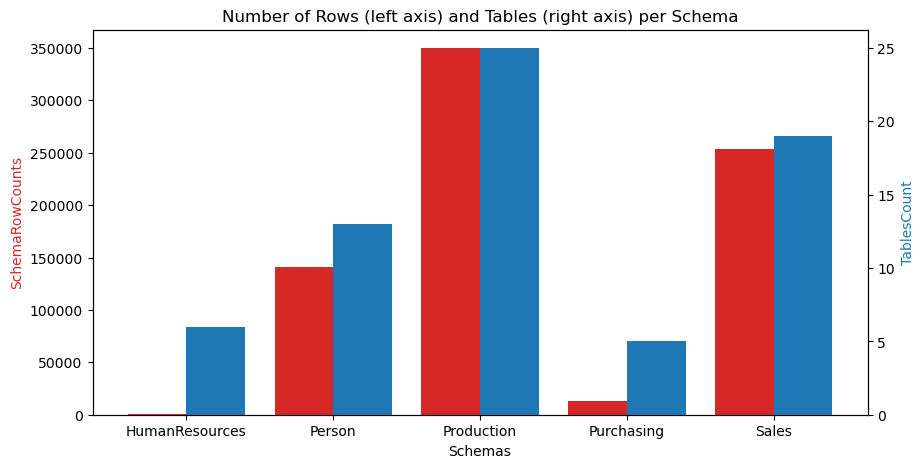

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.bar(schemaoverview_df['Schemas'], schemaoverview_df['SchemaRowCounts'], color=color, width=0.8)
ax1.set_xlabel('Schemas')
ax1.set_ylabel('SchemaRowCounts', color=color)
ax1.set_title('Number of Rows (left axis) and Tables (right axis) per Schema')


ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.bar(schemaoverview_df['Schemas'], schemaoverview_df['Tables'], color=color, width=0.4, align='edge') 
ax2.set_ylabel('TablesCount', color=color)

In [6]:
# Tabell översikt scheman och tabeller - antal rader
DataBase_df.sort_values(by='Schemas', ascending=False)

,Schemas,SchemaRowCounts,Tables,TableRowCounts
67,Sales,253735,Store,701
58,Sales,253735,SalesPerson,17
49,Sales,253735,CountryRegionCurrency,109
50,Sales,253735,CreditCard,19118
51,Sales,253735,Currency,105
...,...,...,...,...
2,HumanResources,934,EmployeeDepartmentHistory,296
1,HumanResources,934,Employee,290
4,HumanResources,934,JobCandidate,13
5,HumanResources,934,Shift,3


In [7]:
query2 = """
SELECT OBJECT_NAME (fk.parent_object_id) AS ChildTable
        ,OBJECT_NAME (fk.referenced_object_id) AS ParentTable
FROM sys.foreign_keys fk
;
"""
DataBaseTablesRelations_df = pd.read_sql(query2, engine)

In [8]:
# Tabell som visar hur tabeller står i relation till varandra.
DataBaseTablesRelations_df

,ChildTable,ParentTable
0,Address,StateProvince
1,BillOfMaterials,Product
2,BillOfMaterials,Product
3,BillOfMaterials,UnitMeasure
4,BusinessEntityAddress,Address
...,...,...
85,Vendor,BusinessEntity
86,WorkOrder,Product
87,WorkOrder,ScrapReason
88,WorkOrderRouting,Location


2.1.2 Produktion

In [9]:
query3 = """
SELECT  
        --B.ProductCategoryID,
        B.Name AS CategoryName
        --, A.ProductSubcategoryID
        , A.Name AS SubcategoryName
        , COUNT (DISTINCT C.ProductID) NoOfProductsSubcat
    FROM Production.ProductSubcategory A
    INNER JOIN Production.ProductCategory B
    ON A.ProductCategoryID = B.ProductCategoryID
    INNER JOIN Production.Product C
    ON A.ProductSubcategoryID = C.ProductSubcategoryID
    WHERE C.DiscontinuedDate IS NULL AND C.SellEndDate IS NULL
    GROUP BY B.ProductCategoryID
        , B.Name
        , A.ProductSubcategoryID
        , A.Name
    ORDER BY B.ProductCategoryID ASC
    ;

"""

ProductStructure_df = pd.read_sql(query3, engine)

# Grupperar efter år och produkt, för kunna beräkna årssumman av produktionskostnaderna
groupedCategory = ProductStructure_df.groupby(['CategoryName'])['NoOfProductsSubcat'].sum() 
ProductStructure_df = ProductStructure_df.set_index(['CategoryName'])
ProductStructure_df['NoOfProductsCategory'] = groupedCategory
ProductStructure_df = ProductStructure_df.reset_index()
ProductStructure_df = ProductStructure_df[['CategoryName', 'NoOfProductsCategory', 'SubcategoryName', 'NoOfProductsSubcat']]


In [10]:
# Tabell som visar Produktkategorier, Subkategorier 
# och antal produkt per sub/kategori för AKTUELLA produkter.
ProductStructure_df

,CategoryName,NoOfProductsCategory,SubcategoryName,NoOfProductsSubcat
0,Bikes,60,Mountain Bikes,20
1,Bikes,60,Road Bikes,18
2,Bikes,60,Touring Bikes,22
3,Components,95,Handlebars,8
4,Components,95,Bottom Brackets,3
5,Components,95,Brakes,2
6,Components,95,Chains,1
7,Components,95,Cranksets,3
8,Components,95,Derailleurs,2
9,Components,95,Mountain Frames,20


In [11]:
query4 = """
WITH TransactionHistoryCombined AS(
   SELECT * FROM Production.TransactionHistory
   UNION ALL
   SELECT * FROM Production.TransactionHistoryArchive
   )

SELECT          YEAR(CTE.TransactionDate) AS Year
                , B.CategoryName
                , SUM(CTE.ActualCost*CTE.Quantity) AS ProductionCost
FROM TransactionHistoryCombined AS CTE
INNER JOIN dbo.ProductStructure AS B
        ON CTE.ProductID = B.ProductID
GROUP BY    YEAR(CTE.TransactionDate)
            , B.CategoryName
ORDER BY B.CategoryName,
         YEAR(TransactionDate)
        """
        
ProductionCostProductStructure_df = pd.read_sql(query4, engine)
ProductionCostProductStructure_df['ProductionCost'] = ProductionCostProductStructure_df['ProductionCost'].astype('int64')

# Grupperar efter år och produkt, för kunna beräkna årssumman av produktionskostnaderna
groupedYear = ProductionCostProductStructure_df.groupby(['Year', 'CategoryName'])['ProductionCost'].sum() 

# Beräkna andelen av totala produktionskostnaderna inom varje kategori.
grouped_percentage = groupedYear / groupedYear.groupby(level=0).transform('sum') * 100


ProductionCostProductStructure_df = ProductionCostProductStructure_df.set_index(['Year', 'CategoryName'])
ProductionCostProductStructure_df['YearlyProductionCostShare%'] = grouped_percentage
ProductionCostProductStructure_df = ProductionCostProductStructure_df.reset_index()

In [12]:
# Tabell som visar produktionskostnader per år och kategori, samt kostandsfördelning mellan kategorierna för varje år.
ProductionCostProductStructure_df.sort_values(by='CategoryName')

,Year,CategoryName,ProductionCost,YearlyProductionCostShare%
0,2011,Accessories,20832,0.142517
1,2012,Accessories,853798,2.006347
2,2013,Accessories,4846023,7.569132
3,2014,Accessories,8147029,17.515233
4,2011,Bikes,13576354,92.879427
5,2012,Bikes,34504526,81.082472
6,2013,Bikes,42566704,66.486067
7,2014,Bikes,19546861,42.023640
8,2011,Clothing,39311,0.268937
9,2012,Clothing,615758,1.446975


C:\Users\46730\AppData\Local\Temp\ipykernel_16532\975003833.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('cividis', len(categories))


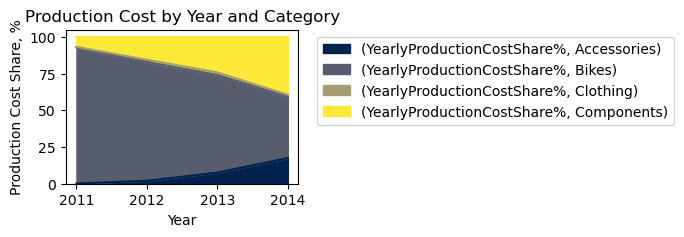

In [16]:
df_filtered = ProductionCostProductStructure_df.drop('ProductionCost', axis=1)

df_reshaped = df_filtered.set_index(['Year', 'CategoryName'])

%matplotlib inline
categories = df_reshaped.index.get_level_values('CategoryName').unique()
cmap = plt.cm.get_cmap('cividis', len(categories)) 

fig, ax = plt.subplots(figsize=(3, 2))
ax = df_reshaped.unstack().plot.area(ax=ax, cmap=cmap)
ax.set_xlabel('Year')
ax.set_ylabel('Production Cost Share, %')
ax.set_title('Production Cost by Year and Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()

2.1.3 Purchase

In [20]:
query5 = """
SELECT 
         YEAR(B.ShipDate) AS Year
        --, MONTH(B.ShipDate) AS ShippedMonth
        , C.CategoryName
        --, A.ProductID
        , SUM(A.LineTotal) AS PurchaseCost
FROM Purchasing.PurchaseOrderDetail AS A
INNER JOIN Purchasing.PurchaseOrderHeader AS B
        ON A.PurchaseOrderID = B.PurchaseOrderID
INNER JOIN dbo.ProductStructure AS C
        ON A.ProductID = C.ProductID
GROUP BY YEAR(B.ShipDate)
            --, MONTH(TransactionDate)
            , C.CategoryName
ORDER BY C.CategoryName,
         YEAR(B.ShipDate)
        -- ,MONTH(B.ShipDate)
;
"""
PurchaseCostProductStructure_df = pd.read_sql(query5, engine)
PurchaseCostProductStructure_df['PurchaseCost'] = PurchaseCostProductStructure_df['PurchaseCost'].astype('int64')

# Grupperar efter år och produkt, för kunna beräkna årssumman av inköpskostnaderna
groupedYear = PurchaseCostProductStructure_df.groupby(['Year', 'CategoryName'])['PurchaseCost'].sum() 

# Beräkna andelen av totala inköpskostnaderna inom varje kategori.
grouped_percentage = groupedYear / groupedYear.groupby(level=0).transform('sum') * 100


PurchaseCostProductStructure_df = PurchaseCostProductStructure_df.set_index(['Year', 'CategoryName'])
PurchaseCostProductStructure_df['YearlyPurchCostShare%'] = grouped_percentage
PurchaseCostProductStructure_df = PurchaseCostProductStructure_df.reset_index()

In [21]:
# Tabell som visar inköpskostnad per kategori och år, samt kostnadsandel mellan kategorier per år
PurchaseCostProductStructure_df.sort_values(by='CategoryName')

,Year,CategoryName,PurchaseCost,YearlyPurchCostShare%
0,2012,Accessories,748232,29.464008
1,2013,Accessories,3908200,32.750025
2,2014,Accessories,8015503,29.889465
3,2013,Clothing,84143,0.705103
4,2014,Clothing,1984327,7.399470
5,2011,Components,192371,100.000000
6,2012,Components,1791246,70.535992
7,2013,Components,7941083,66.544872
8,2014,Components,16817321,62.711065


Text(0.5, 1.0, 'Purchase cost by product category year 2013')

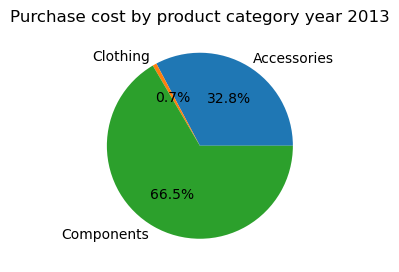

In [23]:
df_filtered = PurchaseCostProductStructure_df[PurchaseCostProductStructure_df.Year == 2013].drop('YearlyPurchCostShare%', axis=1)

fig, ax = plt.subplots(figsize=(3, 4))
ax.pie(df_filtered['PurchaseCost'], autopct='%1.1f%%', labels=df_filtered['CategoryName'])
ax.set_title('Purchase cost by product category year 2013')

2.1.4 Sourcing; Purchase vs Production

In [25]:
PurchaseVSProduction = pd.merge(ProductionCostProductStructure_df, PurchaseCostProductStructure_df, on=['Year', 'CategoryName'], how='outer')
PurchaseVSProduction.drop(['YearlyProductionCostShare%', 'YearlyPurchCostShare%'], axis=1, inplace=True)
PurchaseVSProduction['ProductionCostShare%'] = 100 * ( PurchaseVSProduction['ProductionCost'] / ( PurchaseVSProduction['ProductionCost'] + PurchaseVSProduction['PurchaseCost']))

In [26]:
# Varukostnader fördelade på Produktion och Inköp.
PurchaseVSProduction.sort_values(by='CategoryName')

,Year,CategoryName,ProductionCost,PurchaseCost,ProductionCostShare%
0,2011,Accessories,20832,NaN,NaN
4,2012,Accessories,853798,748232.0,53.294757
8,2013,Accessories,4846023,3908200.0,55.356403
12,2014,Accessories,8147029,8015503.0,50.406886
1,2011,Bikes,13576354,NaN,NaN
5,2012,Bikes,34504526,NaN,NaN
9,2013,Bikes,42566704,NaN,NaN
13,2014,Bikes,19546861,NaN,NaN
2,2011,Clothing,39311,NaN,NaN
6,2012,Clothing,615758,NaN,NaN


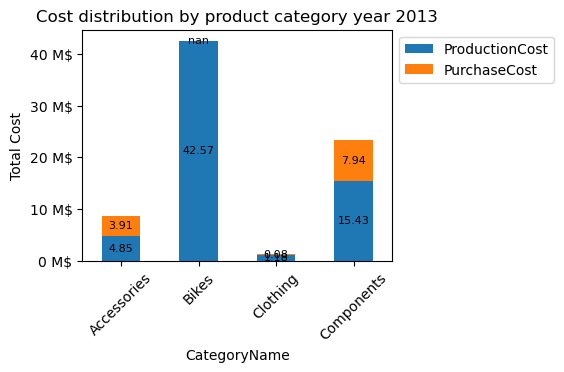

In [27]:
df_filtered2=PurchaseVSProduction[PurchaseVSProduction.Year == 2013].drop(['ProductionCostShare%', 'Year'], axis=1).reset_index(drop=True)   
df_filtered2['ProductionCost']=df_filtered2['ProductionCost'] / 1000000
df_filtered2['PurchaseCost']=df_filtered2['PurchaseCost'] / 1000000

fig, ax = plt.subplots(figsize=(4, 3))
ax = df_filtered2.plot(x='CategoryName', kind='bar', stacked=True, ax=ax) 
    
ax.set_title('Cost distribution by product category year 2013')

ax.set_ylabel('Total Cost')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
formatter = ticker.StrMethodFormatter('{x:,.0f} M$')
ax.yaxis.set_major_formatter(formatter)

# Fixa labels på barsen
bars = ax.containers[0]  # Access the first set of bars (ProductionCost)
bars2 = ax.containers[1]  # Access the second set of bars (PurchaseCost)
# Calculate bar centers and label positions
for i, bar in enumerate(bars):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    ax.annotate(f'{df_filtered2["ProductionCost"][i]:,.2f}', xy=(x, y), ha='center', va='center', fontsize=8)

for i, bar in enumerate(bars2):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2 + bars[i].get_height() 
    ax.annotate(f'{df_filtered2["PurchaseCost"][i]:,.2f}', xy=(x, y), ha='center', va='center', fontsize=8)


2.1.5 Sales

In [28]:
query6 = """
SELECT 
        --B.ShipDate,
         YEAR(B.ShipDate) AS Year
        --, MONTH(B.ShipDate) AS ShippedMonth
        , C.CategoryName
        --, A.ProductID
        , SUM(A.LineTotal) AS Sales
    FROM Sales.SalesOrderDetail AS A
    INNER JOIN Sales.SalesOrderHeader AS B
        ON A.SalesOrderID = B.SalesOrderID
    INNER JOIN dbo.ProductStructure AS C
        ON A.ProductID = C.ProductID
GROUP BY 
        --B.ShipDate,
         YEAR(B.ShipDate)
        --, MONTH(B.ShipDate) AS ShippedMonth
        , C.CategoryName
ORDER BY 
         C.CategoryName,
         --B.ShipDate,
         YEAR(B.ShipDate)
        --, MONTH(B.ShipDate) AS ShippedMonth
;

"""

SalesByCategory_df = pd.read_sql(query6, engine)
SalesByCategory_df['Sales'] = SalesByCategory_df['Sales'].astype('int64')

# Grupperar efter år och kategori, för kunna beräkna årssumman av inköpskostnaderna
groupedYear = SalesByCategory_df.groupby(['Year', 'CategoryName'])['Sales'].sum() 

# Beräkna andelen av totala inköpskostnaderna inom varje kategori.
grouped_percentage = groupedYear / groupedYear.groupby(level=0).transform('sum') * 100


SalesByCategory_df = SalesByCategory_df.set_index(['Year', 'CategoryName'])
SalesByCategory_df['YearlySalesShare%'] = grouped_percentage
SalesByCategory_df = SalesByCategory_df.reset_index()

In [29]:
#Försäljningsintäkter per år fördelade per produktkategori
SalesByCategory_df

,Year,CategoryName,Sales,YearlySalesShare%
0,2011,Accessories,20820,0.166188
1,2012,Accessories,96876,0.310921
2,2013,Accessories,646684,1.501503
3,2014,Accessories,507690,2.198602
4,2011,Bikes,11831956,94.444244
5,2012,Bikes,26849490,86.172626
6,2013,Bikes,35849127,83.236290
7,2014,Bikes,20120598,87.134252
8,2011,Clothing,36031,0.287604
9,2012,Clothing,513903,1.649356


In [30]:
query7 = """
SELECT  YEAR(C.ShipDate) AS Year
        , B.[Group] AS Region
        , B.[Name] AS District
        --, B.CountryRegionCode
        , COUNT(DISTINCT A.CustomerID) AS TotCustomerCount
        , COUNT(DISTINCT A.StoreID) AS StoreCustomerCount
        , COUNT(DISTINCT C.SalesOrderID) AS OrderCount
        , AVG(C.SubTotal) AS AvgOrderSales
        , SUM(C.SubTotal) AS Sales
               
FROM Sales.Customer AS A
LEFT JOIN Sales.SalesTerritory AS B
    ON B.TerritoryID = A.TerritoryID
LEFT JOIN Sales.SalesOrderHeader AS C
    ON A.CustomerID = C.CustomerID
WHERE C.SubTotal IS NOT NULL
GROUP BY 
        --A.CustomerID,
        B.[Name]
       -- , B.CountryRegionCode
        , B.[Group]
        , YEAR(C.ShipDate)
ORDER BY 
      --  A.CustomerID
         B.[Name]
      --  , B.CountryRegionCode
        , B.[Group]
        , YEAR(C.ShipDate)
;
"""

SalesByRegionDistrict_df = pd.read_sql(query7, engine)
SalesByRegionDistrict_df['AvgOrderSales'] = SalesByRegionDistrict_df['AvgOrderSales'].astype('int64')
SalesByRegionDistrict_df['Sales'] = SalesByRegionDistrict_df['Sales'].astype('int64')

# Beräknar årsandelar per Region
groupedYear = SalesByRegionDistrict_df.groupby(['Year', 'Region'])['Sales'].sum() 
grouped_percentage = groupedYear / groupedYear.groupby(level=0).transform('sum') * 100

SalesByRegionDistrict_df = SalesByRegionDistrict_df.set_index(['Year', 'Region'])
SalesByRegionDistrict_df['RegionSalesShare%'] = grouped_percentage
SalesByRegionDistrict_df = SalesByRegionDistrict_df.reset_index()

# Beräknar årsandelar  per District
groupedYear1 = SalesByRegionDistrict_df.groupby(['Year', 'District'])['Sales'].sum() 
grouped_percentage1 = groupedYear1 / groupedYear1.groupby(level=0).transform('sum') * 100

SalesByRegionDistrict_df = SalesByRegionDistrict_df.set_index(['Year', 'District'])
SalesByRegionDistrict_df['DistrictSalesShare%'] = grouped_percentage1
SalesByRegionDistrict_df = SalesByRegionDistrict_df.reset_index()


SalesByRegionDistrict_df = SalesByRegionDistrict_df[['Year',
 'Region',
 'RegionSalesShare%',
 'District',
 'DistrictSalesShare%',
  'TotCustomerCount',
  'StoreCustomerCount',
  'OrderCount',
 'AvgOrderSales',
 'Sales',
 ]]

In [31]:
# Översikt kunder per region och distrikt
SalesByRegionDistrict_df[SalesByRegionDistrict_df.Year == 2013].sort_values(by=['Region', 'Year']) 

,Year,Region,RegionSalesShare%,District,DistrictSalesShare%,TotCustomerCount,StoreCustomerCount,OrderCount,AvgOrderSales,Sales
14,2013,Europe,21.860856,France,8.027553,961,34,1229,2813,3457395
18,2013,Europe,21.860856,Germany,5.513922,1001,32,1181,2010,2374797
38,2013,Europe,21.860856,United Kingdom,8.319381,1181,37,1487,2409,3583083
6,2013,North America,68.614808,Canada,14.501593,1005,89,1825,3422,6245706
10,2013,North America,68.614808,Central,6.905769,53,49,150,19828,2974253
22,2013,North America,68.614808,Northeast,6.427492,50,45,134,20658,2768263
26,2013,North America,68.614808,Northwest,13.783500,1741,74,1988,2986,5936430
30,2013,North America,68.614808,Southeast,5.623874,68,63,177,13684,2422152
34,2013,North America,68.614808,Southwest,21.372581,2339,99,2654,3468,9204979
2,2013,Pacific,9.524336,Australia,9.524336,2404,33,2927,1401,4102046


2.1.6 Person

In [32]:
query8 = """
SELECT PersonType,
COUNT(DISTINCT BusinessEntityID) AS PersonCount
FROM person.Person
GROUP BY PersonType;
"""
PersonOverview_df = pd.read_sql(query8, engine)
PersonOverview_df['PersonTypeName'] = ['Individual (retail) customer','Employee (non-sales)', 'Sales person', 'Store Contact', 'Vendor contact', 'General contact' ]
PersonOverview_df = PersonOverview_df[['PersonType', 'PersonTypeName', 'PersonCount']]



In [87]:
#Overview Person-Schema
PersonOverview_df

,PersonType,PersonTypeName,PersonCount
0,IN,Individual (retail) customer,18484
1,EM,Employee (non-sales),273
2,SP,Sales person,17
3,SC,Store Contact,753
4,VC,Vendor contact,156
5,GC,General contact,289


2.1.7 Human Resources

In [101]:
query9 = """
SELECT  B.[Name] AS DepartmentName
        , COUNT (DISTINCT C.JobTitle) AS JobTilteCount
        , COUNT(A.BusinessEntityID) AS EmployeeCount
        , CAST(COUNT(CASE WHEN C.Gender = 'F' THEN 1 END) * 1.0 / COUNT(A.BusinessEntityID) AS DECIMAL(10,2)) AS ShareOfFemales
        , AVG(D.Rate) AS AvgSalary
        , AVG(C.SickLeaveHours) AS AvgSickLeaveHours
FROM HumanResources.EmployeeDepartmentHistory AS A
LEFT JOIN HumanResources.Department AS B
        ON A.DepartmentID = B.DepartmentID
LEFT JOIN HumanResources.Employee AS C
        ON A.BusinessEntityID = C.BusinessEntityID
LEFT JOIN HumanResources.EmployeePayHistory AS D
        ON A.BusinessEntityID = D.BusinessEntityID
WHERE A.EndDate IS NULL AND C.CurrentFlag ='1'
GROUP BY       B.[Name]
;
"""
HROverview_df = pd.read_sql(query9, engine)

In [102]:
# Översikt HR-schemat filtrerat på aktiva anställda vid databasens senaste datum.
HROverview_df

,DepartmentName,JobTilteCount,EmployeeCount,ShareOfFemales,AvgSalary,AvgSickLeaveHours
0,Document Control,3,5,0.20,14.3884,58
1,Engineering,4,6,0.50,40.1442,21
2,Executive,2,4,0.75,68.3034,32
3,Facilities and Maintenance,4,7,0.29,13.0316,64
4,Finance,6,10,0.50,23.9350,49
5,Human Resources,4,6,0.33,18.0248,45
6,Information Services,5,10,0.40,34.1586,54
7,Marketing,3,11,0.36,18.4318,41
8,Production,15,195,0.24,13.5537,43
9,Production Control,3,8,0.00,16.7746,42


### 2.2   Statistisk analys av valfri del av datan. 

2.2.1 Introduktion  
Tanken är titta på bruttovinst definierad som (faktiska intäkter - faktisk produktionskostnad - inköpskostnad)
och bruttomarginalmarginal (bruttovinst /  faktiska intäkter).  
Faktiska intäkter definieras som UnitPrice * (1-UnitPriceDiscount) vilket är samma sak som LineTotal / OrderQty.  

Syftet är att förstå AdventureWorks lönsamhet bättre genom att gräva i vart bruttomarginal är hög/låg osv.
  
För att göra uppgiften hanterlig väljer jag att avgränsa mig till uppgifter avseende det sista helåret i databasen, år 2013.  
Jag kommer att jämföra Produktkategorier, men gräva vidare i den kategori som genererar klart mest intäkter :  
Bikes (83% av försäljning år 2013, se tabell i föregående avsnitt) 
Där kommer jag att titta på subkategorier, men även jämföra kunder utifrån geografi och butik/individ-kunder.


2.2.2 SQL - Skapa dataset

Börjar med att skapa nedan views, som sedan läses ihop till en dataframe. Får inte VIEWS att funka med SQLALCHEMY på samma sätt som vanliga queries, så jag klipper in dem nedan som text.  
Notera att jag filtrera bort NULL-värden under skapandet av Views.

-----------------------
- Sales & Customers 
-----------------------

CREATE OR ALTER VIEW SalesCustomerProduct2013 AS

WITH Sales2013CollapseProductCustomer AS(  
SELECT   
        B.CustomerID  
         , A.ProductID  
         , SUM(A.OrderQty) AS SoldQty  
         , AVG(A.UnitPrice) AS AvgListPrice  
         , (SUM(A.LineTotal) / SUM(A.OrderQty) ) AS AvgPricePaid  
         , SUM(A.LineTotal) AS Sales  
         , SUM(A.OrderQty * A.UnitPrice) AS ListPriceSales  
         , COUNT(DISTINCT A.SalesOrderID) AS SalesOrderCount  
         , AVG(B.TerritoryID) AS TerritoryID  
      
FROM Sales.SalesOrderDetail AS A  
        LEFT JOIN Sales.SalesOrderHeader AS B  
        ON A.SalesOrderID = B.SalesOrderID   

WHERE YEAR(B.ShipDate) = 2013   
        AND A.OrderQty IS NOT NULL  
        AND A.UnitPrice IS NOT NULL  
        AND A.LineTotal IS NOT NULL    
GROUP BY B.CustomerID, A.ProductID  
)  
SELECT  
        CTE.CustomerID  
        , CTE.ProductID  
        , CTE.SoldQty  
        , CTE.AvgListPrice  
        , CTE.AvgPricePaid  
        , CTE.Sales  
        , CTE.ListPriceSales  
        , CTE.SalesOrderCount  
        , CASE WHEN D.StoreID IS NOT NULL THEN 1 ELSE 0 END AS StoreFlag    
        , C.[Name] AS SalesDistrict  
        , C.[Group] AS SalesRegion  

FROM Sales2013CollapseProductCustomer AS CTE  
    LEFT JOIN Sales.SalesTerritory AS C  
       ON CTE.TerritoryID = C.TerritoryID  
    LEFT JOIN Sales.Customer AS D  
       ON CTE.CustomerID = D.CustomerID  
;

-----------------------
- Production Costs --
-----------------------
Brytet mellan TransactionHistory och TransactionHistoryArchive går -mellan 2013-07-30 och  2013-07-31
Börjar med att slå  ihop dem i en CTE  

CREATE OR ALTER VIEW ProductionCostProduct2013 AS  

WITH TransactionHistoryCombined AS(  
   SELECT * FROM Production.TransactionHistory    
    UNION ALL    
   SELECT * FROM Production.TransactionHistoryArchive     
)
  
SELECT         
        CTE2.ProductID  
        , SUM(CTE2.Quantity) AS ProducedQty   
        , SUM(CTE2.ActualCost * CTE2.Quantity) AS TotActProductionCosts  
        , SUM(CTE2.ActualCost * CTE2.Quantity) / SUM(CTE2.Quantity) AS AvgActProductionCost  
       
FROM TransactionHistoryCombined AS CTE2  
     WHERE YEAR(CTE2.TransactionDate) = 2013   
      AND CTE2.Quantity IS NOT NULL  
        AND CTE2.ActualCost IS NOT NULL    
     GROUP BY CTE2.ProductID
;


--------------------
- Purchase Costs
--------------------
CREATE OR ALTER VIEW PurchaseCostProduct2013 AS

SELECT 
        B.ProductID    
        , SUM(B.OrderQty) AS PurchasedQty  
        , SUM(B.LineTotal) AS TotPurchasedCost  
        , SUM(B.LineTotal) / SUM(B.OrderQty) AS AvgPurchasedCost  

FROM Purchasing.PurchaseOrderDetail AS B  
    LEFT JOIN Purchasing.PurchaseOrderHeader AS A  
    ON A.PurchaseOrderID = B.PurchaseOrderID  
 WHERE YEAR(A.ShipDate) = 2013  
  AND B.OrderQty IS NOT NULL  
        AND B.LineTotal IS NOT NULL   
 GROUP BY B.ProductID   
;

-----------------------
- Product Structure
-----------------------

CREATE OR ALTER VIEW ProductStructure  
AS
SELECT 
        B.ProductCategoryID  
        , B.Name AS CategoryName  
        , A.ProductSubcategoryID  
        , A.Name AS SubcategoryName  
        , C.ProductID  
        , C.Name AS ProductName  
        , C.MakeFlag AS MakeFlag  

FROM Production.ProductSubcategory A  
    INNER JOIN Production.ProductCategory B  
    ON A.ProductCategoryID = B.ProductCategoryID  
    INNER JOIN Production.Product C  
    ON A.ProductSubcategoryID = C.ProductSubcategoryID  
    ;


Läser därefter in en query utifrån ovan views via SQLAlchemy.

In [33]:
query10 = """
SELECT  
        A.CustomerID
        , A.SalesOrderCount
        , A.StoreFlag
        , A.SalesDistrict
        , A.SalesRegion
        , A.ProductID
        , D.ProductName
        , D.CategoryName
        , D.SubcategoryName
        , D.MakeFlag
        , A.SoldQty
        , A.AvgListPrice
        , A.AvgPricePaid
        , A.Sales
        , A.ListPriceSales
        , A.ListPriceSales - A.Sales AS LossDueToDiscount 
        , B.ProducedQty
        , B.AvgActProductionCost
        , B.AvgActProductionCost * A.SoldQty AS TotActProductionCosts
        , C.PurchasedQty
        , C.AvgPurchasedCost
        , C.TotPurchasedCost
        , COALESCE(B.AvgActProductionCost + C.AvgPurchasedCost, B.AvgActProductionCost, C.AvgPurchasedCost, 0)  AS TotProductCost
        , A.AvgPricePaid - COALESCE(B.AvgActProductionCost + C.AvgPurchasedCost, B.AvgActProductionCost, C.AvgPurchasedCost, 0) AS ProductCustomerGP
        , ROUND(((A.AvgPricePaid - COALESCE(B.AvgActProductionCost + C.AvgPurchasedCost, B.AvgActProductionCost, C.AvgPurchasedCost, 0))/A.AvgPricePaid), 2) AS ProductCustomerGM

        FROM SalesCustomerProduct2013 AS A

        LEFT JOIN ProductionCostProduct2013 AS B
        ON B.ProductID = A.ProductID

        LEFT JOIN PurchaseCostProduct2013 AS C
        ON C.ProductID = A.ProductID

        LEFT JOIN ProductStructure AS D
        ON D.ProductID = A.ProductID
    ;
"""
AnalysisMain_df = pd.read_sql(query10, engine)



2.1.3 Granskning av datasetet
  
Börjar med att dubbelkolla att inga NULL, som inte bör finnas, har följt med.


In [34]:
null_df = AnalysisMain_df.isnull()
column_sums = null_df.sum(axis=0)
column_sums

CustomerID                   0
SalesOrderCount              0
StoreFlag                    0
SalesDistrict                0
SalesRegion                  0
ProductID                    0
ProductName                  0
CategoryName                 0
SubcategoryName              0
MakeFlag                     0
SoldQty                      0
AvgListPrice                 0
AvgPricePaid                 0
Sales                        0
ListPriceSales               0
LossDueToDiscount            0
ProducedQty                  0
AvgActProductionCost         0
TotActProductionCosts        0
PurchasedQty             28032
AvgPurchasedCost         28032
TotPurchasedCost         28032
TotProductCost               0
ProductCustomerGP            0
ProductCustomerGM            0
dtype: int64

NULL för purchased-variablerna var väntat i och med att jag utgåt ifrån säljdatan och gjort left join.   
De produkter som tillverkas helt inhouse bör inte ha några data på inköpssidan.

Däremot hade jag väntat mig att produkter som är rena trade-produkter (inte har någon MakeFlag) inte skulle ha några   
värden i produktionskolumnerna. Mer om detta strax.

Outliers. En ordentlig analys skulle behöva gå tillbaka till grunddatan och söka efter outliers i alla grund-värdekolumner grupperade per productID.
Jag nöjer mig i detta sammanhang med att titta på distributionen av ProductGM. I och med att den bygger på ett antal kolumner i grunddatan kan jag åtminstonefånga upp outliers med stor inverkan.

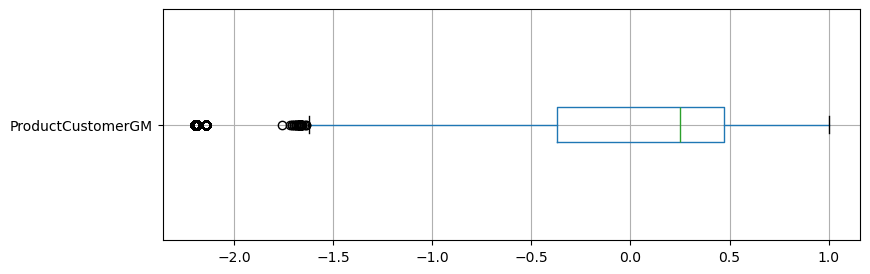

In [35]:
AnalysisMain_df.boxplot(column='ProductCustomerGM', figsize=(9,3), vert=False)
plt.show()

In [36]:
AnalysisMain_df['ProductCustomerGM'].describe()

count    43044.000000
mean        -0.131840
std          0.834239
min         -2.200000
25%         -0.370000
50%          0.250000
75%          0.470000
max          1.000000
Name: ProductCustomerGM, dtype: float64

Notera skillnaden mellan Median i boxploten (> 0) jämfört med medelvärde/mean i tabellen ( < 0).

Här är det uppenbarligen något fel. En stor dela av raderna har en negativ GrossMargin. GrossMargin förväntas vara positiv i de flesta fall.   

Åter till det faktum att alla rader i vår dataframe har en produktionskostnad, även de med en inköpskostnad.   
Jag grupperar datan på produktnivå och tittar på raderna med sämst GM.


In [37]:
filtered_df = AnalysisMain_df.groupby('ProductName')[['MakeFlag' ,'AvgPricePaid' , 'AvgActProductionCost' , 'AvgPurchasedCost', 'TotProductCost' , 'ProductCustomerGM']].mean()
df_sorted = filtered_df.sort_values('ProductCustomerGM')
df_sorted.head(10)

,MakeFlag,AvgPricePaid,AvgActProductionCost,AvgPurchasedCost,TotProductCost,ProductCustomerGM
ProductName,,,,,,
LL Road Tire,0.0,21.490000,34.1400,34.5788,68.7188,-2.200000
Road Tire Tube,0.0,3.990000,6.1834,6.5310,12.7144,-2.190000
ML Road Tire,0.0,24.990000,39.0401,39.4718,78.5119,-2.140000
HL Road Tire,0.0,32.600000,43.3419,43.7105,87.0524,-1.670000
Touring Tire,0.0,28.990000,37.6173,37.8840,75.5013,-1.600000
Front Brakes,0.0,63.811358,82.5961,82.8345,165.4306,-1.593708
ML Mountain Seat/Saddle,0.0,23.454340,30.3878,30.4395,60.8273,-1.593509
HL Mountain Pedal,0.0,48.561292,62.8121,62.9895,125.8016,-1.591818
HL Road Seat/Saddle,0.0,31.584000,40.9176,40.9395,81.8571,-1.590000


Ovan tabell visar produkterna med sämst genomsnittlig GM. Det är tydligt att de både har en produktionskostnad  OCH en inköpskostnad som överstiger försäljningskostnaden.  
Resultatet i det "värsta fallet" är en negativ GM om 220%(!)
  
Av dokumentation över databasen framgår avseende MakeFlag att "0 = Product is purchased, 1 = Product is manufactured in-house".  
Det är märkligt att ovan produkter har MakeFlag=0, men ändå har en produktionskostnad.

Tar en titt på hur många rader som bara produktionskostnad, bara inköpskostnad samt både ock, fördelat på MakeFlag:

In [38]:
AnalysisMain_df['OnlyProductionC'] = (AnalysisMain_df['AvgActProductionCost'] > 0) & ((AnalysisMain_df['AvgPurchasedCost'] ==0) | (pd.isna(AnalysisMain_df['AvgPurchasedCost'])))
AnalysisMain_df['OnlyPurchaseC'] = (AnalysisMain_df['AvgPurchasedCost'] > 0) & ((AnalysisMain_df['AvgActProductionCost'] ==0) | (pd.isna(AnalysisMain_df['AvgActProductionCost'])))
AnalysisMain_df['BothPurchProdC'] = (AnalysisMain_df['AvgPurchasedCost'] > 0) & (AnalysisMain_df['AvgActProductionCost'] > 0)

filtered_df2 = AnalysisMain_df.groupby('MakeFlag')[['OnlyProductionC' ,'OnlyPurchaseC' , 'BothPurchProdC']].sum()
filtered_df2


,OnlyProductionC,OnlyPurchaseC,BothPurchProdC
MakeFlag,,,
False,12140,0,15012
True,15892,0,0


In [39]:
result=12140+15892+15012
result


43044

In [40]:
AnalysisMain_df.shape

(43044, 28)

Dubbelkollar att summan av Bool-variablerna stämmer med antalet rader i stora tabellen.

Det finns alltså 12 140 rader som ska vara inköpsvaror, men inte har någon inköpskostnad - bara produktionskostnad.   Skulle kunna vara att inköpen har skett innan 2013.  
Finns också 15 012 rader som har både inköps och produktionskostnad, men är en inköpsvara (MakeFlag = False).  
Jag börjar tro att värdena som dyker upp som actual cost i Production-schemat inkluderar inköpskostnader.

Jag tittar på hur marginalen varierar mellan MakeFlag 1/0, samt vilka kostnader som finns tillgängliga:

In [41]:
def costvalues(row):
    if row['OnlyProductionC']:
        return 'OnlyProductionC'
    elif row['OnlyPurchaseC']:
        return 'OnlyPurchaseC'
    else:
        return 'BothPurchProdC'

AnalysisMain_df['CostValues'] = AnalysisMain_df.apply(costvalues, axis=1)


filtered_df3 = AnalysisMain_df.groupby(['MakeFlag', 'CostValues'])[['ProductCustomerGM']].agg(['count', 'mean', 'min', 'max', 'std'])
filtered_df3


ProductCustomerGM                                
                                     count      mean   min   max       std
MakeFlag CostValues                                                       
False    BothPurchProdC              15012 -1.058399 -2.20  0.06  0.709864
         OnlyProductionC             12140  0.109856 -0.95  0.37  0.212669
True     OnlyProductionC             15892  0.558778 -0.31  1.00  0.204705

Uppenbarligen är marginalerna tokiga på om inte alla, så iaf en väsentlig del av de rader som både har produktions- och inköpskostnader.  
Det skulle kunna vara så att det blir korrekt om inköpskostnaderna helt enkelt tas bort från marginalberäkningen.   
Jag är dock inte helt säker på att så är fallet, så jag väljer istället att helt ta bort alla de rader som har en inköpskostnad.  

In [42]:
AnalysisMain1_df = AnalysisMain_df[~AnalysisMain_df['BothPurchProdC']]
AnalysisMain1_df.drop(columns=['PurchasedQty', 'AvgPurchasedCost', 'TotPurchasedCost', 'OnlyProductionC', 'OnlyPurchaseC', 'BothPurchProdC'], inplace=True)

C:\Users\46730\AppData\Local\Temp\ipykernel_12084\884874898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AnalysisMain1_df.drop(columns=['PurchasedQty', 'AvgPurchasedCost', 'TotPurchasedCost', 'OnlyProductionC', 'OnlyPurchaseC', 'BothPurchProdC'], inplace=True)


In [43]:
filtered_df4 = AnalysisMain1_df.groupby(['MakeFlag', 'CostValues'])[['ProductCustomerGM']].agg(['count', 'mean', 'min', 'max', 'std'])
filtered_df4

ProductCustomerGM                                
                                     count      mean   min   max       std
MakeFlag CostValues                                                       
False    OnlyProductionC             12140  0.109856 -0.95  0.37  0.212669
True     OnlyProductionC             15892  0.558778 -0.31  1.00  0.204705

Bekräftar att operationerna gav väntat resultat.  
Noterar även att av de två kategorier som blir kvar , så GM väsentligt högre på de som har MakeFlag. Mer om det senare.



2.2.3 Analys av GM - jämförelse per kategori och subkategori
  
Tar en titt på GM igen efter borttagning av alla poster med både inköps- och produktionskostnader

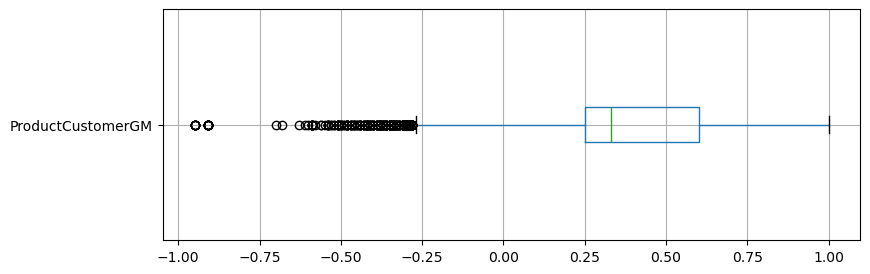

In [44]:
AnalysisMain1_df.boxplot(column='ProductCustomerGM', figsize=(9,3), vert=False)
plt.show()

En rimligare bild än tidigare, men ett antal Outliers identifierade av Pandas.
Vi tar en titt på raderna med lägst GM:

In [176]:
AnalysisMain1_df[['CustomerID', 'ProductID', 'ProductName', 'CategoryName', 'MakeFlag', 'AvgPricePaid', 'AvgListPrice', 'AvgActProductionCost', 'ProductCustomerGP', 'ProductCustomerGM' ]].sort_values('ProductCustomerGM').head(50)

,CustomerID,ProductID,ProductName,CategoryName,MakeFlag,AvgPricePaid,AvgListPrice,AvgActProductionCost,ProductCustomerGP,ProductCustomerGM
15007,29811,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
37767,29874,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
38410,29570,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
38407,29805,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
19634,29591,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
13319,29761,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
12268,30039,707,"Sport-100 Helmet, Red",Accessories,False,13.383675,15.7455,26.1075,-12.723825,-0.95
41147,29761,711,"Sport-100 Helmet, Blue",Accessories,False,13.383675,15.7455,25.4973,-12.113625,-0.91
37081,30039,711,"Sport-100 Helmet, Blue",Accessories,False,13.383675,15.7455,25.4973,-12.113625,-0.91
15685,29591,711,"Sport-100 Helmet, Blue",Accessories,False,13.383675,15.7455,25.4973,-12.113625,-0.91


Det är ganska få ProductID som återkommer flera gånger.  
Alla är handelsvaror (MakeFlag=False) och tillhör kategorierna Accessories eller Clothing. Man skulle kunna tänka sig att de har reats ut.  
Det skulle isf yttra sig med ett AvgListPrice > AvgActProductionCost, och en stor skillnad mellan AvgPricePaid och AvgListPrice. Så är dock inte fallet. Rabatterna är relativt små, AvgListPrice är väsentligt lägre än  AvgActProductionCost.  
En ytterligar aspekt är att jag här tittar på faktiska kostnader. Priserna till kund är säkert satta efter de standardkostnader som också finns i Databasen. Utredning av hur standardkostander avviker mot faktiska kostnader  lämnas utanför denna uppgift.

Vi tittar djupare på GM fördelat på CategoryName och MakeFlag.


In [45]:
filtered_df5 = AnalysisMain1_df.groupby(['MakeFlag', 'CategoryName'])[['ProductCustomerGM']].agg(['count', 'mean', 'min', 'max', 'std'])
filtered_df5

ProductCustomerGM                                
                                  count      mean   min   max       std
MakeFlag CategoryName                                                  
False    Accessories               6228  0.140157 -0.95  0.37  0.202361
         Clothing                  5912  0.077935 -0.70  0.34  0.218532
True     Bikes                    11425  0.479746 -0.31  0.68  0.158399
         Components                4467  0.760913  0.34  1.00  0.167561

Alla kategorier är antingen MakeFlag=True eller MakeFlag=False., och de som är = True har högst GM.  
Observera att detta är ovägda medelvärden.

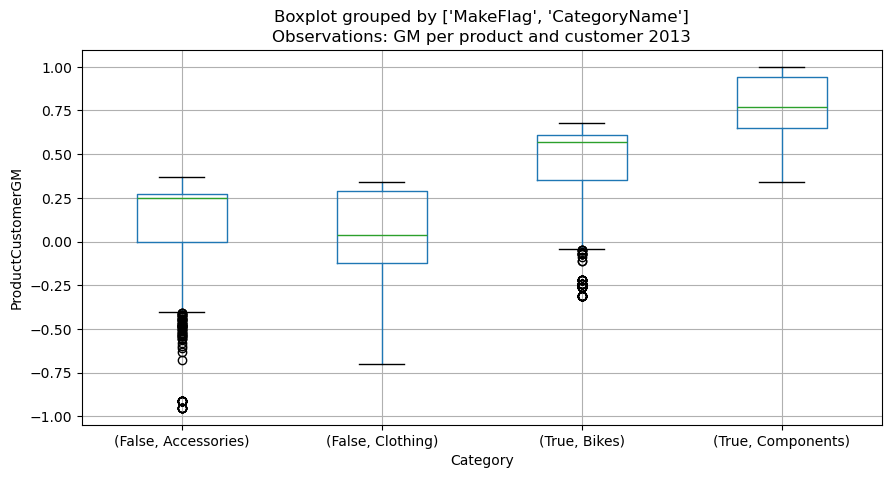

In [47]:
AnalysisMain1_df.boxplot(column='ProductCustomerGM', by=['MakeFlag','CategoryName'], figsize=(10, 5))
plt.title('Observations: GM per product and customer 2013')
plt.ylabel('ProductCustomerGM')
plt.xlabel('Category')
plt.show()


Visualisering av fördelning och identifiering av Outliers. Outliers identifierade av Pandas på Accessories och Bikes.

Hittills har jag tittat på data grupperad på kund och produkt. Ett sätt att analysera inverkan av ovan outliers är att se om det fortfarande finns outliers om vi grupperar på artikelnivå, alltså summerar ihop olika kunders köp av artikeln.


C:\Users\46730\AppData\Local\Temp\ipykernel_12084\1285248808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AnalysisMain1_df['ProductCustomerGPSUM']= AnalysisMain1_df['SoldQty'] * AnalysisMain1_df['ProductCustomerGP']


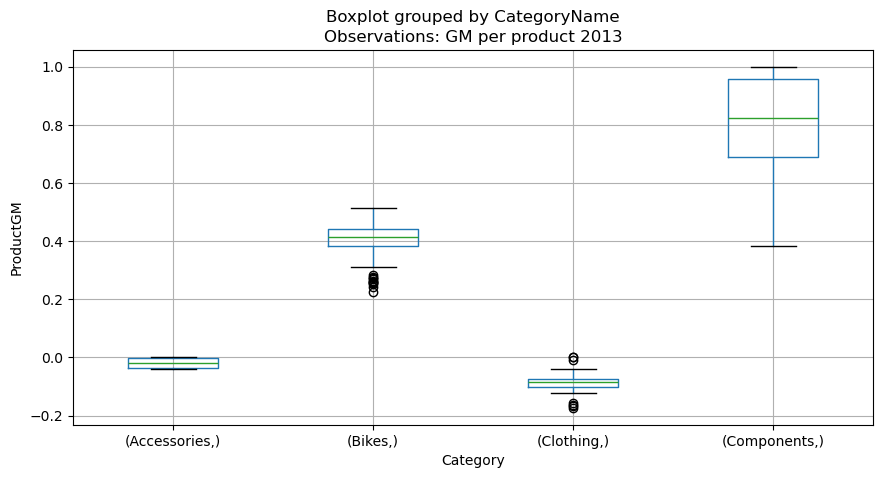

In [48]:
AnalysisMain1_df['ProductCustomerGPSUM']= AnalysisMain1_df['SoldQty'] * AnalysisMain1_df['ProductCustomerGP']
filtered_df6 = AnalysisMain1_df.groupby(['ProductID', 'ProductName', 'CategoryName']).agg({'ProductCustomerGPSUM': 'sum', 'Sales': 'sum'})

filtered_df6['ProductGMAgg']= filtered_df6['ProductCustomerGPSUM'] / filtered_df6['Sales']

filtered_df6.boxplot(column='ProductGMAgg', by=['CategoryName'], figsize=(10, 5))
plt.title('Observations: GM per product 2013')
plt.ylabel('ProductGM')
plt.xlabel('Category')

plt.show()

Det är tydligt att Outliers behöver analyseras utifrån kategori. Vi tar även en titt på subkategori.

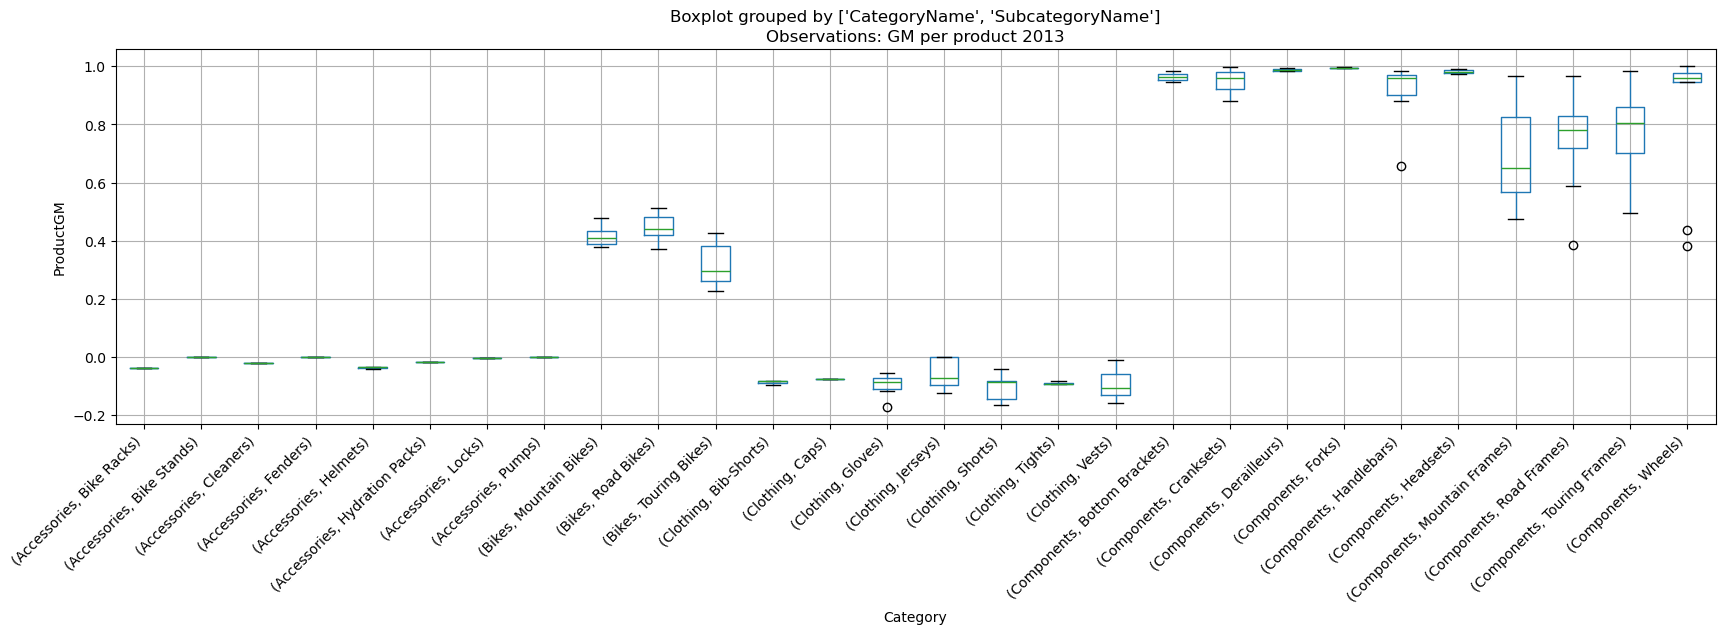

In [49]:
filtered_df7 = AnalysisMain1_df.groupby(['ProductID', 'ProductName', 'CategoryName', 'SubcategoryName']).agg({'ProductCustomerGPSUM': 'sum', 'Sales': 'sum'})

filtered_df7['ProductGMAgg']= filtered_df7['ProductCustomerGPSUM'] / filtered_df7['Sales']

filtered_df7.boxplot(column='ProductGMAgg', by=['CategoryName', 'SubcategoryName'], figsize=(20, 5))
plt.title('Observations: GM per product 2013')
plt.ylabel('ProductGM')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')

plt.show()

Ju längre vi gräver oss ner i kategorierna desto färre blir outliers.Det är ganska tydligt att outliers inte kan analyseras på totalen utan utifrån Subkategori.

En iaktagelse är att företaget verkar ha en tydlig strategi för vart GM för varje Category ska ligga. De olika subkategorierna håller relativt samma nivå.

Jag lämnar outliers utan åtgärd och avrundar denna övergripande analys av GM med en överblick av sales och grossprofit per kategori innan jag går vidare till en liten fördjupning inom kategorin Bikes.

In [50]:
filtered_df8 = AnalysisMain1_df.groupby('CategoryName').agg({'Sales': 'sum', 'ProductCustomerGPSUM': 'sum'})
filtered_df8.loc['Total'] = AnalysisMain1_df.sum()

total_sales = filtered_df8['Sales'].iloc[:-1].sum()
total_ProductGPSUM = filtered_df8['ProductCustomerGPSUM'].iloc[:-1].sum()

filtered_df8['Sales_Share'] = filtered_df8['Sales'] / total_sales
filtered_df8['GP_Share'] = filtered_df8['ProductCustomerGPSUM'] / total_ProductGPSUM
filtered_df8['GM'] = filtered_df8['ProductCustomerGPSUM'] / filtered_df8['Sales']

styled_df = filtered_df8.style.format({'Sales': '{:,.0f}', 'ProductCustomerGPSUM': '{:,.0f}', 'Sales_Share': '{:.2%}', 'GP_Share': '{:.2%}', 'GM': '{:.2%}'})
styled_df

,Sales,ProductCustomerGPSUM,Sales_Share,GP_Share,GM
CategoryName,,,,,
Accessories,"494,142","-14,658",1.16%,-0.08%,-2.97%
Bikes,"35,849,127","14,713,041",84.29%,79.96%,41.04%
Clothing,"854,402","-95,556",2.01%,-0.52%,-11.18%
Components,"5,333,035","3,797,106",12.54%,20.64%,71.20%
Total,"42,530,706","18,399,933",100.00%,100.00%,43.26%


In [51]:
AggGP = (AnalysisMain1_df['ProductCustomerGP'] * AnalysisMain1_df['SoldQty']).sum()
AggGM = AggGP / (AnalysisMain1_df['Sales']).sum()
AggGM


0.4326270288545101

2.2.4 Analys av GM - kategori BIKES  
Börjar med att skapa en reducerad datatabell att jobba med.

In [52]:
AnalysisBikes_df = AnalysisMain1_df[AnalysisMain_df['CategoryName'] == 'Bikes']

C:\Users\46730\AppData\Local\Temp\ipykernel_12084\3823917109.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  AnalysisBikes_df = AnalysisMain1_df[AnalysisMain_df['CategoryName'] == 'Bikes']


Tittar därefter på subkategorierna mer i detalj. Tittar nu igen på Product/Customer data.

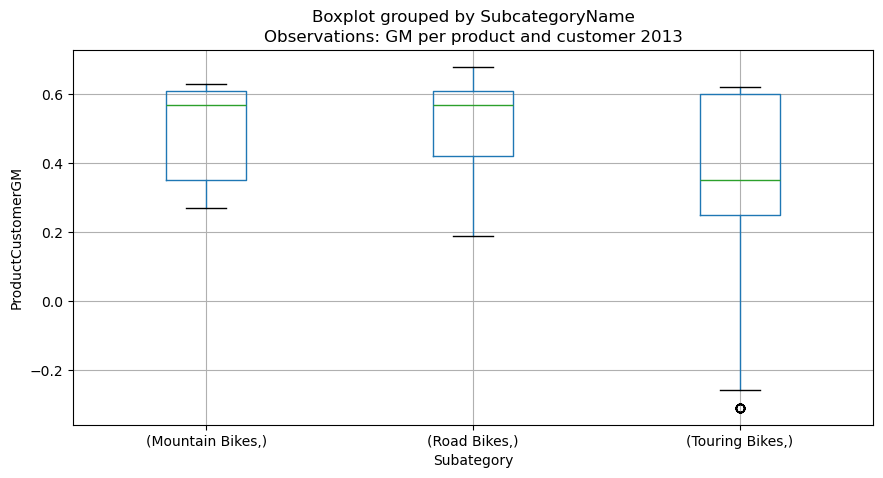

In [53]:
AnalysisBikes_df.boxplot(column='ProductCustomerGM', by=['SubcategoryName'], figsize=(10, 5))
plt.title('Observations: GM per product and customer 2013')
plt.ylabel('ProductCustomerGM')
plt.xlabel('Subategory')
plt.show()

Touringbikes ligger överlag lägre och har också större spridning.  
Outliers är nu i det närmsta eliminerade.

In [54]:
filtered_df9 = AnalysisBikes_df.groupby('SubcategoryName').agg({'Sales': 'sum', 'ProductCustomerGPSUM': 'sum'})
filtered_df9.loc['Total'] = AnalysisBikes_df.sum()

total_sales = filtered_df9['Sales'].iloc[:-1].sum()
total_ProductGPSUM = filtered_df9['ProductCustomerGPSUM'].iloc[:-1].sum()

filtered_df9['Sales_Share'] = filtered_df9['Sales'] / total_sales
filtered_df9['GP_Share'] = filtered_df9['ProductCustomerGPSUM'] / total_ProductGPSUM
filtered_df9['GM'] = filtered_df9['ProductCustomerGPSUM'] / filtered_df9['Sales']

styled_df = filtered_df9.style.format({'Sales': '{:,.0f}', 'ProductCustomerGPSUM': '{:,.0f}', 'Sales_Share': '{:.2%}', 'GP_Share': '{:.2%}', 'GM': '{:.2%}'})
styled_df

,Sales,ProductCustomerGPSUM,Sales_Share,GP_Share,GM
SubcategoryName,,,,,
Mountain Bikes,"13,013,975","5,605,368",36.30%,38.10%,43.07%
Road Bikes,"15,245,154","6,613,685",42.53%,44.95%,43.38%
Touring Bikes,"7,589,998","2,493,988",21.17%,16.95%,32.86%
Total,"35,849,127","14,713,041",100.00%,100.00%,41.04%


Road Bikes står för störst del av försäljningen och har också högst både GP och GM, tätt följd av Mountain Bikes.  
Touring Bikes säljer för betydligt mindre, och har också sämre GM.

Vi tittar vidare genom att dela upp kunderna på om de är butik eller inte.

In [55]:
filtered_df10 = AnalysisBikes_df.groupby(['StoreFlag', 'SubcategoryName'])[['ProductCustomerGM']].agg(['count', 'mean', 'min', 'max', 'std'])
filtered_df10

ProductCustomerGM                                
                                      count      mean   min   max       std
StoreFlag SubcategoryName                                                  
0         Mountain Bikes               2214  0.602114  0.56  0.63  0.022564
          Road Bikes                   2914  0.609331  0.55  0.68  0.034250
          Touring Bikes                 978  0.602853  0.58  0.62  0.010185
1         Mountain Bikes               1589  0.360227  0.27  0.48  0.057122
          Road Bikes                   2290  0.386716  0.19  0.56  0.065002
          Touring Bikes                1440  0.225597 -0.31  0.37  0.155278

OBS, ovägda medel - kan ej direkt jämföras med tabellen ovan. 
   
Vi ser här en tydlig skillnad mellan individkunder och butikskunder. GM är betydligt lägre till butiker.  
Vi ser också här att den övergripande skillnaden på Touring Bikes gentemot de andra två tycks varar att de har ännu lägre marginal till butiker, men lika hög till individer.


Vi tänker oss att den data vi har är ett urval ur en population av potentiell försäljning till butik och individer.   
Jag testar om bruttomarginalen hos försäljning av Touringcyklar till butiker är signifikant lägre än till privatpersoner.  
Först tittar jag om datan ser ut att vara normalfördelad.

In [72]:
TouringIndividualFiltered_df = AnalysisBikes_df[(AnalysisBikes_df['SubcategoryName'] == 'Touring Bikes') & (AnalysisBikes_df['StoreFlag'] == 0)]
TouringStoreFiltered_df = AnalysisBikes_df[(AnalysisBikes_df['SubcategoryName'] == 'Touring Bikes') & (AnalysisBikes_df['StoreFlag'] == 1)]

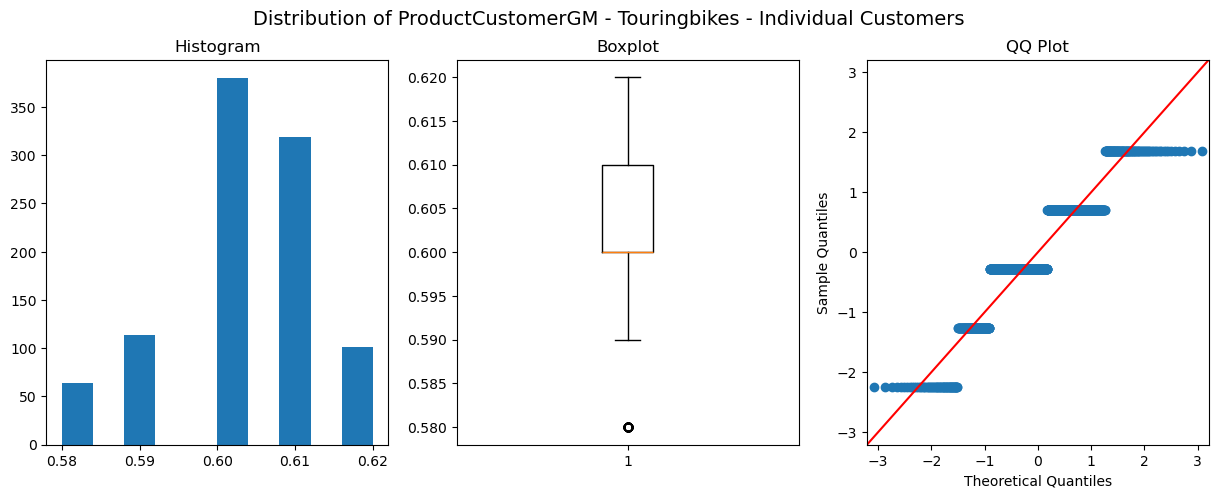

In [78]:

%matplotlib inline

Fig, axs = plt.subplots (1, 3, figsize= (15,5))

axs[0].hist(TouringIndividualFiltered_df['ProductCustomerGM'])
axs[0].set_title('Histogram')

axs[1].boxplot(TouringIndividualFiltered_df['ProductCustomerGM'])
axs[1].set_title('Boxplot')

sm.qqplot(TouringIndividualFiltered_df['ProductCustomerGM'], line='45', fit = True, ax=axs[2])
axs[2].set_title('QQ Plot')

plt.suptitle('Distribution of ProductCustomerGM - Touringbikes - Individual Customers') 

plt.show()

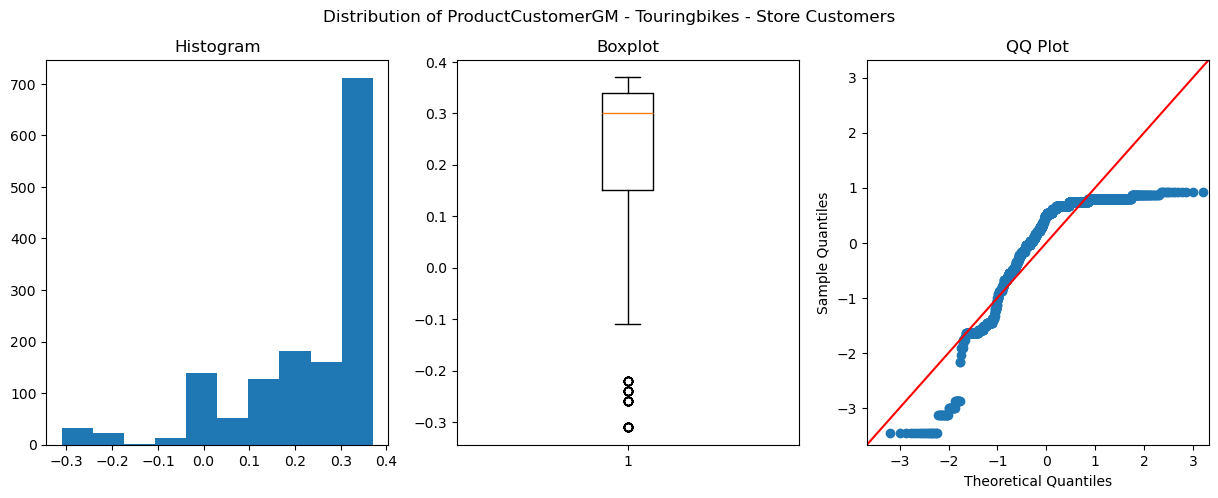

In [81]:

%matplotlib inline

Fig, axs = plt.subplots (1, 3, figsize= (15,5))

axs[0].hist(TouringStoreFiltered_df['ProductCustomerGM'])
axs[0].set_title('Histogram')

axs[1].boxplot(TouringStoreFiltered_df['ProductCustomerGM'])
axs[1].set_title('Boxplot')

sm.qqplot(TouringStoreFiltered_df['ProductCustomerGM'], line='45', fit = True, ax=axs[2])
axs[2].set_title('QQ Plot')

plt.suptitle('Distribution of ProductCustomerGM - Touringbikes - Store Customers') 

plt.show()

In [73]:
st.shapiro(TouringIndividualFiltered_df['ProductCustomerGM'])

ShapiroResult(statistic=0.8967087814958142, pvalue=4.181392162317416e-25)

In [74]:
st.shapiro(TouringStoreFiltered_df['ProductCustomerGM'])

ShapiroResult(statistic=0.7965751645563932, pvalue=4.035887392399717e-39)

Ingen av serierna är normalfördelade. Rent grafiskt ser det ut som att försäljningen till individkunder har det. Shapiro-Wilk testen visar dock att så inte är fallet.  
Jag gör ändå ett test. H0 är att medelvärden hos försäljning till individkunder och butikskunder inte skiljer sig åt.

In [80]:
t_stat, p_value = st.ttest_ind(TouringIndividualFiltered_df['ProductCustomerGM'], TouringStoreFiltered_df['ProductCustomerGM'])

print('t-statistik:', t_stat)
print('p-värde:', p_value)

t-statistik: 75.86374805412768
p-värde: 0.0


Ett p-värde på noll indikerar att vi kan utesluta H0 - det finns en statistisk skillnad. Vilket inte är överranskande med tanke på hur stor skillnaden var mellan medelvärdena och uteseendet på respektive dataseries boxplot.




Vi fortsätter genom att fördela upp resultaten per säljregioner:

In [56]:
grouped_df = AnalysisBikes_df.groupby(['StoreFlag', 'SubcategoryName', 'SalesRegion'])['ProductCustomerGM'].mean().unstack()
grouped_df

SalesRegion                  Europe  North America   Pacific
StoreFlag SubcategoryName                                   
0         Mountain Bikes   0.604609       0.604624  0.595253
          Road Bikes       0.609402       0.606843  0.611613
          Touring Bikes    0.603614       0.601821  0.603333
1         Mountain Bikes   0.360847       0.360076  0.362778
          Road Bikes       0.384548       0.387050  0.370000
          Touring Bikes    0.218754       0.227564  0.228439

Högst marginella skillnader mellan säljregioner.
Vi tittar på de olika distrikten också:

In [57]:
grouped_df = AnalysisBikes_df.groupby(['StoreFlag', 'SubcategoryName', 'SalesDistrict'])['ProductCustomerGM'].mean().unstack()
grouped_df

SalesDistrict              Australia    Canada   Central    France   Germany  \
StoreFlag SubcategoryName                                                      
0         Mountain Bikes    0.595253  0.605743  0.570000  0.604811  0.602464   
          Road Bikes        0.611613  0.607209  0.590000  0.609387  0.607831   
          Touring Bikes     0.603333  0.601176       NaN  0.603673  0.603437   
1         Mountain Bikes    0.362778  0.360700  0.358841  0.363500  0.353824   
          Road Bikes        0.370000  0.387640  0.386752  0.381593  0.390755   
          Touring Bikes     0.228439  0.228380  0.247447  0.197315  0.231206   

SalesDistrict              Northeast  Northwest  Southeast  Southwest  \
StoreFlag SubcategoryName                                               
0         Mountain Bikes    0.580000   0.604361   0.570000   0.604651   
          Road Bikes        0.600000   0.607771        NaN   0.606161   
          Touring Bikes          NaN   0.603113        NaN   0.601366   
1         Mountain Bikes    0.362030   0.358651   0.354913   0.363422   
          Road Bikes        0.388532   0.390850   0.385065   0.385653   
          Touring Bikes     0.236897   0.236102   0.202925   0.221182   

SalesDistrict              United Kingdom  
StoreFlag SubcategoryName                  
0         Mountain Bikes         0.606163  
          Road Bikes             0.610681  
          Touring Bikes          0.603732  
1         Mountain Bikes         0.360614  
          Road Bikes             0.384586  
          Touring Bikes          0.224583

Inga stora skillnader.  
Tittar vi på mountainbikes är det lägsta värdet i district Central (57%) och det högsta är United Kingdom (60,6%).  
Vi leker med tanken att dessa inköp är ett representativt urval av en större mängd potentiella köp, och vi vill testa om medelvärden hos två regioner är signifikant skillda från varandra.

Vi tittar hur många datapunkter vi har, för att se vart det finns tillräckligt mycket data.

In [60]:
grouped_df = AnalysisBikes_df.groupby(['StoreFlag', 'SubcategoryName', 'SalesDistrict'])['ProductCustomerGM'].count().unstack()
grouped_df


SalesDistrict              Australia  Canada  Central  France  Germany  \
StoreFlag SubcategoryName                                                
0         Mountain Bikes       592.0   148.0      1.0   212.0    207.0   
          Road Bikes           955.0   129.0      1.0   310.0    332.0   
          Touring Bikes        231.0    68.0      NaN    98.0    128.0   
1         Mountain Bikes        18.0   300.0    164.0   100.0     34.0   
          Road Bikes             1.0   428.0    274.0   113.0     53.0   
          Touring Bikes        237.0   179.0     47.0   108.0    141.0   

SalesDistrict              Northeast  Northwest  Southeast  Southwest  \
StoreFlag SubcategoryName                                               
0         Mountain Bikes         1.0      321.0        1.0      473.0   
          Road Bikes             1.0      314.0        NaN      461.0   
          Touring Bikes          NaN      106.0        NaN      205.0   
1         Mountain Bikes       133.0      252.0      173.0      301.0   
          Road Bikes           252.0      200.0      231.0      605.0   
          Touring Bikes         87.0      236.0      106.0      203.0   

SalesDistrict              United Kingdom  
StoreFlag SubcategoryName                  
0         Mountain Bikes            258.0  
          Road Bikes                411.0  
          Touring Bikes             142.0  
1         Mountain Bikes            114.0  
          Road Bikes                133.0  
          Touring Bikes              96.0

Jag väljer att testa skillnaden mellan Mountainbikes i Australien och Southwest för individkunder. Skillnaden i medelvärde mellan dessa är 0,94 procentenhet.  
  
Jag tittar på datan för att se om den är normalfördelad.

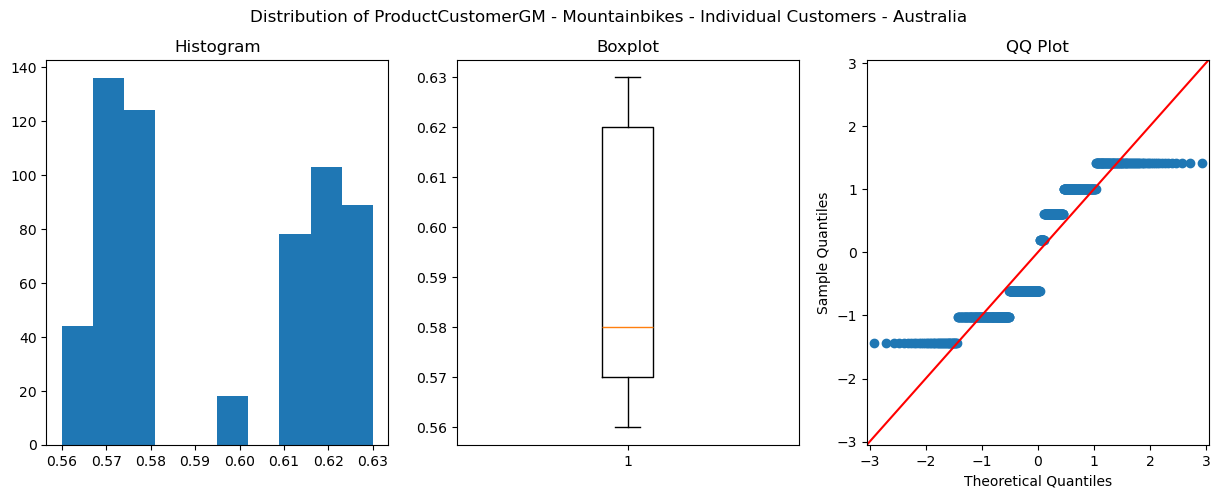

In [83]:
MTBAustraliaFiltered_df = AnalysisBikes_df[(AnalysisBikes_df['SubcategoryName'] == 'Mountain Bikes') & (AnalysisBikes_df['SalesDistrict'] == 'Australia') & (AnalysisBikes_df['StoreFlag'] == 0)]
%matplotlib inline

Fig, axs = plt.subplots (1, 3, figsize= (15,5))

axs[0].hist(MTBAustraliaFiltered_df['ProductCustomerGM'])
axs[0].set_title('Histogram')

axs[1].boxplot(MTBAustraliaFiltered_df['ProductCustomerGM'])
axs[1].set_title('Boxplot')

sm.qqplot(MTBAustraliaFiltered_df['ProductCustomerGM'], line='45', fit = True, ax=axs[2])
axs[2].set_title('QQ Plot')

plt.suptitle('Distribution of ProductCustomerGM - Mountainbikes - Individual Customers - Australia') 

plt.show()

In [62]:
MTBAustraliaFiltered_df['ProductCustomerGM'].describe()

count    592.000000
mean       0.595253
std        0.024618
min        0.560000
25%        0.570000
50%        0.580000
75%        0.620000
max        0.630000
Name: ProductCustomerGM, dtype: float64

Det ser inte ut som att datan är normalfördelad.  
Jag gör ett Shapiro-Wilk-test där H0 är att datan är normalfördelad.

In [63]:
st.shapiro(MTBAustraliaFiltered_df['ProductCustomerGM'])

ShapiroResult(statistic=0.8571598608202218, pvalue=9.42952692275797e-23)

Testet genererar ett väldigt lågt p-värde, vilket innebär att H0 förkastas; datan i MTBAustraliaFiltered_df är inte normalfördelad.  
  
Jag gör samma sak för Southwest:

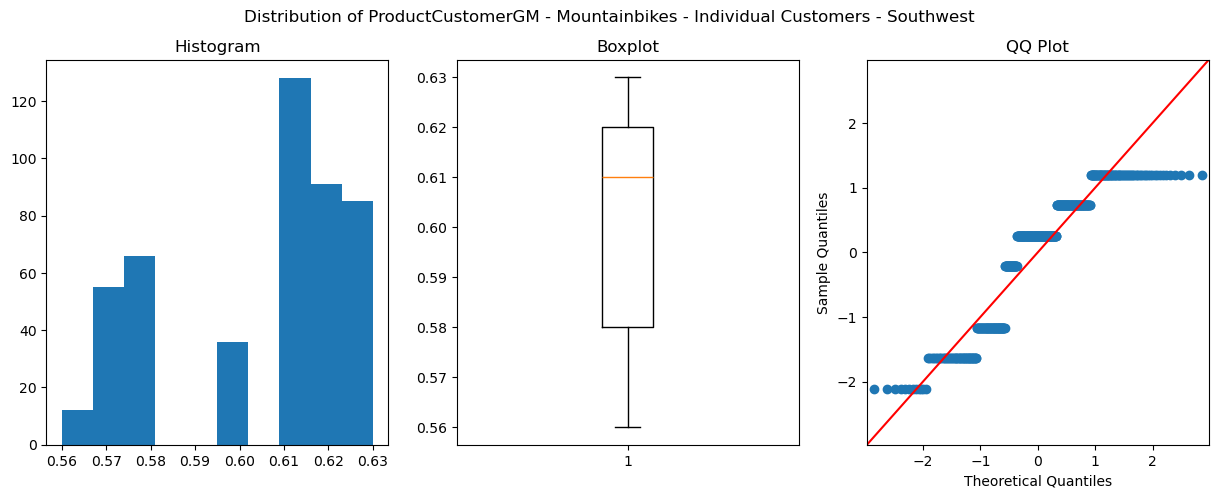

In [84]:
MTBSouthwestFiltered_df = AnalysisBikes_df[(AnalysisBikes_df['SubcategoryName'] == 'Mountain Bikes') & (AnalysisBikes_df['SalesDistrict'] == 'Southwest') & (AnalysisBikes_df['StoreFlag'] == 0)]
%matplotlib inline

Fig, axs = plt.subplots (1, 3, figsize= (15,5))

axs[0].hist(MTBSouthwestFiltered_df['ProductCustomerGM'])
axs[0].set_title('Histogram')

axs[1].boxplot(MTBSouthwestFiltered_df['ProductCustomerGM'])
axs[1].set_title('Boxplot')

sm.qqplot(MTBSouthwestFiltered_df['ProductCustomerGM'], line='45', fit = True, ax=axs[2])
axs[2].set_title('QQ Plot')

plt.suptitle('Distribution of ProductCustomerGM - Mountainbikes - Individual Customers - Southwest') 

plt.show()

In [65]:
MTBSouthwestFiltered_df['ProductCustomerGM'].describe()

count    473.000000
mean       0.604651
std        0.021121
min        0.560000
25%        0.580000
50%        0.610000
75%        0.620000
max        0.630000
Name: ProductCustomerGM, dtype: float64

In [66]:
st.shapiro(MTBSouthwestFiltered_df['ProductCustomerGM'])

ShapiroResult(statistic=0.8730567579039982, pvalue=3.2771235927994573e-19)

Inte heller datan för Southwest är normalfördelad. Jag gör ändå ett oberoende t-test. H0 är då att medelvärdena inte skiljer sig åt.

In [67]:
t_stat, p_value = st.ttest_ind(MTBAustraliaFiltered_df['ProductCustomerGM'], MTBSouthwestFiltered_df['ProductCustomerGM'])

print('t-statistik:', t_stat)
print('p-värde:', p_value)

t-statistik: -6.588034685132369
p-värde: 6.997703057137662e-11


Ett väldigt lågt p-värde indikerar att vi kan förkasta H0. Det finns alltså en statistiskt säkerstäld skillnad. Med tanke på att datan inte är normalfördelad ska dock resultaten tolkas med försiktighet.  
För underhållning beräknar jag också konfidensintervallen för respektive medelvärde, för att kontrollera att de inte överlappar.

In [68]:
mean= np.mean(MTBAustraliaFiltered_df['ProductCustomerGM'])
std = np.std((MTBAustraliaFiltered_df['ProductCustomerGM']), ddof=1)
n = np.size((MTBAustraliaFiltered_df['ProductCustomerGM']))

t.interval(0.95, n-1, mean, std/np.sqrt(n))

(0.5932662608275906, 0.5972404959291661)

In [244]:
mean= np.mean(MTBSouthwestFiltered_df['ProductCustomerGM'])
std = np.std((MTBSouthwestFiltered_df['ProductCustomerGM']), ddof=1)
n = np.size((MTBSouthwestFiltered_df['ProductCustomerGM']))

t.interval(0.95, n-1, mean, std/np.sqrt(n))

(0.6027428164913107, 0.6065595090900846)

#### 2.3 Resultaten av analysen  
Det första delen av analysarbetet ägnades åt att gräva djupare i datan vilket ledde till insikten att den inte riktigt var uppbyggd på det sätt som jag förväntade mig.
Medelvärdet av GM per produkt/kund år 2013 var negativt och hade en extremt bred spridning. Granskning av fallen med sämst GM ledde till insikten att även rena inköpsartiklar hade en actual cost i Production-schemat. 
GM analyserades uppdelade på vilka kostnadsposter som fanns registrerade, samt huruvida produktion är markerad som in-house producerad eller inköpt via variabeln ”MakeFlag”. Inköpsprodukter med både inköpskostnad och produktionskostnad har en genomsnittlig GM på -105%. Det är orimligt. 
I och med att det för mig inte var helt tydligt hur datan var upplagd valde jag att exkludera alla rader med både inköps och produktionskostnad i det fortsatta analysen.
Här behöver företaget AdventureWorks säkerställa att datan är upplagd på det sätt de önskar samt möjligtvis tydliggöra i dokumentationen definitioner och samband över hur kostnader hänger ihop, för att underlätta för tredjepartsanalytiker och ny personal.

Även med det nya datasetet var spridningen på GM stor. Den varierade mellan +100% och näst intill -100%. På den negativa sidan är det ett antal Accessories och Clothing-artiklar som sticker ut. Alla med MakeFlag = False, dvs. de är handelsvaror som köps in från externa leverantörer. Eftersom vi kan se både ”listpris” och faktiskt pris efter rabatt kan vi utesluta att dessa är kraftigt rabatterade. Det är istället genomsnittlig kostnad som är betydligt högre än både list- och betalat pris.  Här behöver AdventureWorks djupdyka och se varför marginalerna är så dåliga. Ett intressant nästa steg skulle kunna vara att titta på de standard costs som finns i systemet, och se om de skiljer sig från de faktiska.
Jag tittade vidare på GM uppdelat per kategori och det framgick tydligt att marginalerna skiljer sig mellan kategorierna. Accessorie och Clothing, vilka är handelsvaror, har låga marginaler. Bikes och Components (som produceras själva av Adventure Works) har högre marginaler.  Detta är naturligt då Adventureworks alltså står för större del av den värdeskapande kedjan för de senare två kategorierna.
Analysen ovan skedde på data där varje observation är en oviktad kombination av produkt, kund och år. I nästa steg summerade jag på kundnivå och fick således en viktad GM per artikel. Median per kategori sjönk då något för Accessories, Clothing och Bikes, men höjdes något för Components. Det tyder på att försäljning till kunder som har köpt större kvantiteter har skett till lägre marginal för Accessories, Clothing och Bikes, vilket är en vanlig strategi. 
Därefter gjorde jag samma övning som ovan uppdelad på subkategorier. Det blev väldigt tydligt att subkategorierna inom respektive överkategori håller ungefär samma nivå. Det tyder på att AdventureWorks har en uttänkt prissättningsstrategi baserad på kategori, som man håller sig till.
Det är tydligt att kategorien Bikes, somt står för 84% av omsättningen och genererar 80% av bruttovinsten är företagets motor. Components går också bra med 12,5 % av omsättningen och 21% av bruttovinsten – där är alltså bruttomarginalen högre.
Kategorierna Accesories och Clothing står däremot för obetydliga delar av omsättning, och genererar inte heller någon bruttovinst. Här bör AdvnetureWorks överväga om det är värt att ha kvar de delarna. Hur mycket overheadresurser läggs på dessa delar? Säkert en del inköpsresurser samt lageryta. Å andra sidan kanske de är nödvändiga för att dra försäljning till de närade kategorierna Accesories och Clothing (?). 

Slutligen tittar jag djupare på kategorien Bikes. Mountainbikes och Road Bikes står för ungefär lika stor del av försäljning och bruttovinst. De har en bruttomarginal på ca 43%. Touringbikes står för ungefär en femtedel av försäljningen och har en bruttomarginal på ca 33%.
Delar man upp försäljningen på slutkundförsäljning och försäljning till butiker så blir det tydligt att marginalen till slutkunder är tämligen lika över alla tre subkategorierna, medan Touringcyklar säljs med lägre marginal till butiker.  Skillnaden testas statistiskt och kan bekräftas, även om resultaten ska tolkas något försiktigt då ingen av dataserierna är normalfördelade. Här skulle man önska att en bekräftelse från AdventureWorks ledning att de låga marginalerna på Touringbikes till butiker är en medveten strategi pga. t.ex. rådande konkurrensförhållanden, eller om det är något som skett oavsiktligt och kan/bör åtgärdas.

En uppdelning av GM baserad på kategori och säljdistrikt och säljregion görs. Sett till medelvärde av GM sticker ingen region ut. Ett statistikst test av GM vid försäljning av mountainbikes till Australien respektive Southwest utförst. Den visar sig signifikant trots att medelvärden ligger när varandra. Ingen av serierna är dock normalfördelade vilket gör resultatet mindre tillförlitligt. 
Om AdventureWorks är intresserade av skillnader i GM baserat på deras kunders geografiska hemvist skulle jag inte säga att datan ger starkt stöd för sådana. Att GM inte varierar mellan regionerna kan både bero på likartade konkurrensförhållanden mellan de olika geografiska marknaderna, men kan också bero på att AdventureWorks använder sig av en och samma prissättningsstrategi rakt av. 


#### 2.4 Executive summary
Det råder viss osäkerhet kring kostandsdatan i AdventureWorks databas. Det bör säkerställas att det är korrekt att även handelsartiklar har en produktionskostnad.    
  
Adventure Works verkar ha en uttänkt strategi med bruttomarginaler som ska hållas beroende på kategori. Strategin efterlevs.    
  
Kategorierna Accessories och Clothes generar låg försäljning och dåliga bruttomarginaler. AdventureWorks bör överväga om verksamheten bör renodlas från dessa kategorier, om lönsamheten kan höjas, eller om de böver finnas kvar för att skapa ett helhetserbjudande.    
  
TouringBikes säljs med lägre marginal till butiker än Mountainbikes och Roadbikes. Kan något göras för att höja marginalen till de andra cykeltypernas nivå?  
  
För "dålig" data för att säkert kunna hävda säkerställda geografiska skillnader i bruttomarginal. Finns potential för AdventureWorks att diversifiera sin prissättning ytterligare i denna aspekt?

#### 2.5 Datum för muntliga presentation
Maila länk till Antonio 24/12.

## 3  Självvärdering  

#### 3.1 Utmaningar du haft under arbetet samt hur du hanterat dem.    
SQL tycker jag känns bra - det känns som ett mindre krångligt språkt samt att det i mycket hanterar funktionalitet som jag är hyggligt van att jobba med, om än i excel.  
Svårare var att den lilla Python vi lärde oss tidigare kändes som bortblåst. Jag har varit tvungen att lägga mycket tid på att gå tillbaka till både Python-boken, filmerna samt använt mig av AI och google för att få till de tabeller och grafer jag önskat.  
  
En annan utmaning har varit tiden. Då jag inte har någon laptop var jag tvungen att få ihop arbetet innan familjens avresa till fjällen. Det har nog tyvärr resulterat i ett längre och mindre genomarbetat material än jag annars skulle ge ifrån mig. Håll till godo!  
  
#### 3.2 Vilket betyg du anser att du skall ha och varför.  
Jag känner mig inte supernöjd med inlämningen. Hade gärna jobbat igenom den mer. Kortat den och gjort den mer kärnfull.  
När jag läser igenom betygdkriterierna i inlämningsuppgiften och Kursplanen känner jag nog dock att jag har gjort ett hyggligt avancerat arbete på en nivå som nog är VG.

#### 3.3 Tips du hade gett till dig själv i början av kursen nu när du slutfört den.
Nej, kursen hade jag inte kunnat göra så annorlunda. Tipset till mig själv är nog isådana fall att efter den Python vi hade i förra kursen försöka ha något litet Python-pill varje idag, istället för att släppa den helt.   
Jag tror det hade varit bättre för mig om den Python vi gjorde i förra kursen hade legat sist i den, istället för först.